In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

##### Continuing from Part A with the interactive features

In [3]:
clean_df = pd.read_csv("cleaned_new_train_data.csv")

In [4]:
clean_df['x23_x29'] = clean_df['x23'] * clean_df['x29']
clean_df['x23_x31'] = clean_df['x23'] * clean_df['x31']
clean_df['x29_x31'] = clean_df['x29'] * clean_df['x31']
clean_df['x5_x23'] = clean_df['x5'] * clean_df['x23']
clean_df['x5_x29'] = clean_df['x5'] * clean_df['x29']

clean_df['x23_log'] = np.log1p(clean_df['x23'])
clean_df['x29_log'] = np.log1p(clean_df['x29'])
clean_df['x31_log'] = np.log1p(clean_df['x31'])
clean_df['x5_log']  = np.log1p(clean_df['x5'])

clean_df.head()

,y,x5,x9,x10,x11,x12,x13,x14,x15,x16,...,x31_qbin,x23_x29,x23_x31,x29_x31,x5_x23,x5_x29,x23_log,x29_log,x31_log,x5_log
0,1,50,5,5,5,4,3,5.0,3,3,...,4,4032,50.0,457.142857,1050,9600,3.091042,5.262690,1.218157,3.931826
1,1,44,1,1,1,1,3,3.0,1,4,...,1,0,0.0,2326.500000,0,45496,0.000000,6.942157,1.178655,3.806662
2,0,72,3,1,5,5,3,2.0,2,3,...,1,0,0.0,3267.000000,0,104544,0.000000,7.281386,1.178655,4.290459
3,0,38,1,3,1,3,5,1.0,5,5,...,1,0,0.0,2061.000000,0,34808,0.000000,6.821107,1.178655,3.663562
4,1,37,5,5,5,5,2,5.0,5,4,...,1,0,0.0,877.500000,0,14430,0.000000,5.968708,1.178655,3.637586


In [5]:
model_cols_b = [
    col for col in clean_df.columns
    if col not in ['y'] 
    and '_qbin' not in col
    and '_decile' not in col
    and '_log' not in col
    and '_x' not in col  # if you used interactions
]
model_cols_b

['x5',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16',
 'x17',
 'x18',
 'x19',
 'x20',
 'x21',
 'x22',
 'x23',
 'x28',
 'x29',
 'x31',
 'x4',
 'x3_Male',
 'x25_LC',
 'x26_PT']

In [6]:
X = clean_df[model_cols_b]
y = clean_df['y']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [8]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
train_auc = roc_auc_score(y_train, rf.predict_proba(X_train)[:,1])
val_auc = roc_auc_score(y_val, rf.predict_proba(X_val)[:,1])
test_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

train_auc, val_auc, test_auc

(1.0, 0.9940314851878786, 0.9933859491556624)

##### Training AUC as exactly shows that the model is overfitting and we need to control the params

##### Hyperparameter tuning for RandomForestClassifier model

In [12]:
param_dist = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [5, 8, 12, 16, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.7]
}

rf_cv = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    random_state=42
)

rf_cv.fit(X_train, y_train)
best_rf = rf_cv.best_estimator_

##### To check the best params for the random classifier model

In [19]:
print(best_rf)

RandomForestClassifier(class_weight='balanced', max_features=0.7,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=400, random_state=42)


##### To handle overfitting:
##### we can limit tree depth, increase min sample leaf, reduce max features, use fewer trees, use cross validation (Instead of trusting a single validation split, cross-validation evaluates model performance across multiple folds)
##### To address the issue of overfitting RandomizedSearchCV systematically explores combinations of these hyperparameters and selects the model that achieves the highest average AUC across all cross-validation folds, not just training data.

In [18]:
train_auc = roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1])
train_auc

0.9996253694515481

Validation Accuracy : 0.964
Validation Precision: 0.970
Validation Recall   : 0.946
Validation F1       : 0.958


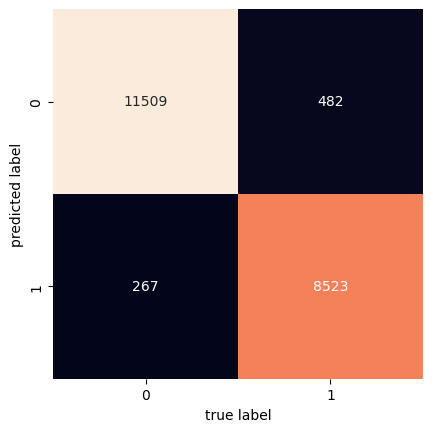

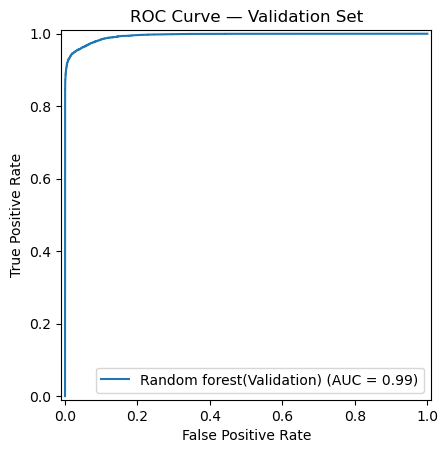

In [24]:
y_val_pred = best_rf.predict(X_val)
print("Validation Accuracy : %.3f" % metrics.accuracy_score(y_val, y_val_pred))
print("Validation Precision: %.3f" % metrics.precision_score(y_val, y_val_pred))
print("Validation Recall   : %.3f" % metrics.recall_score(y_val, y_val_pred))
print("Validation F1       : %.3f" % metrics.f1_score(y_val, y_val_pred))

cm = metrics.confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

# val ROC Curve
val_pred_proba = best_rf.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, val_pred_proba)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                          name='Random forest(Validation)')
display.plot()

plt.title("ROC Curve — Validation Set")
plt.show()

Test Accuracy : 0.962
Test Precision: 0.969
Test Recall   : 0.942
Test F1       : 0.955


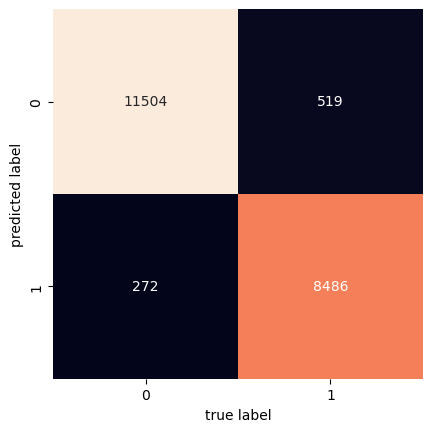

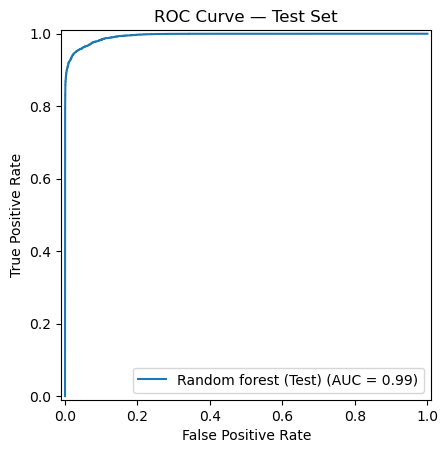

In [23]:
# TEST predictions
y_test_pred = best_rf.predict(X_test)

print("Test Accuracy : %.3f" % metrics.accuracy_score(y_test, y_test_pred))
print("Test Precision: %.3f" % metrics.precision_score(y_test, y_test_pred))
print("Test Recall   : %.3f" % metrics.recall_score(y_test, y_test_pred))
print("Test F1       : %.3f" % metrics.f1_score(y_test, y_test_pred))

cm = metrics.confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
# Test ROC Curve
test_pred_proba = best_rf.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, test_pred_proba)
roc_auc_test = auc(fpr_test, tpr_test)

display = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test,
                          name='Random forest (Test)')
display.plot()

plt.title("ROC Curve — Test Set")
plt.show()

##### To check the feature importnace

In [21]:
importances = best_rf.feature_importances_
feat_imp = pd.DataFrame({"feature": X_train.columns, "importance": importances})
feat_imp.sort_values("importance", ascending=False).head(15)

,feature,importance
6,x14,0.324723
1,x9,0.176446
22,x26_PT,0.104613
16,x28,0.097675
8,x16,0.044364
21,x25_LC,0.034436
0,x5,0.023732
12,x20,0.023285
10,x18,0.020930
17,x29,0.019111


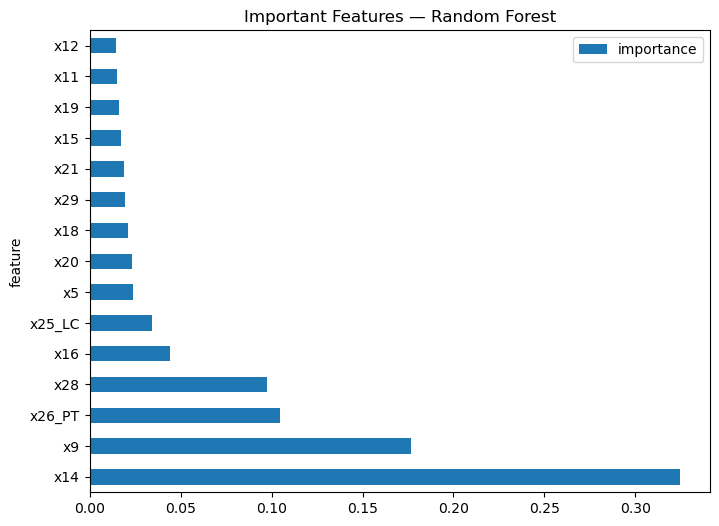

In [22]:
feat_imp.sort_values("importance", ascending=False).head(15).plot(
    x='feature',
    y='importance',
    kind='barh',
    figsize=(8,6)
)
plt.title("Important Features — Random Forest")
plt.show()